# Exploratory Data Analysis & Building Machine Learning Data Table
# _Factors affecting vessel delays at US Army Corps of Engineers-managed locks on US waterways._

## Springboard Data Science Career Track, Capstone 2
***
* Author: Heather A. Passmore
* Data: United States Army Corps of Engineers, Lock Performance Management System
* Capstone Description: Project Proposal (add link)
* Initial Data Approach: Data Wrangling (create, add link)
***
## Table of Contents
1. Import Dataframes from Previous Step & Calculate 75th percentile delay per lock
2. Apply Defined Delay Per Lock to Each Vessel Record (row) 
3. Explore patterns of delay per EROC, River, Lockage, Lock
4. Assign Delay Cateogories HIGH or LOW to Individual Locks Based on Proportion of Delays
5. Explore Patterns in Delay Count by Year, Month, Day for Vessels
6. Examine Delays Per Lock & Per Day
7. Start to Build Focal DataFrame for Machine Learning
8. Delete unneccesary columns, create full and reduced datasets for ML

## 1. Import Dataframes from Previous Step & Calculate 75th percentile delay per lock

In [2]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

# Figures inline, visualization style
%matplotlib inline

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
# Bring traf_sample_updated dataframe into workspace: random sample plus some calculated columns
# load the pickled traf_sample_updated DataFrame from hard drive in 'rb' mode
with open('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/traf_sample_updated.pickle','rb') as f:
    traf_sample_updated = pickle.load(f)

In [4]:
# Bring no_zero_delay dataframe into workspace
# load the pickled no_zero_delay DataFrame from hard drive in 'rb' mode
with open('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/no_zero_delay.pickle','rb') as f:
    no_zero_delay = pickle.load(f)

In [35]:
# Read rivermstr csv for river_names
rivermstr = pd.read_csv('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/RIVERMSTR.csv', 
                    index_col=None, header = 0)

In [5]:
# check columns of traf_sample_updated
traf_sample_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392000 entries, 2093451 to 488481
Data columns (total 27 columns):
EROC                    392000 non-null object
RIVER_CODE              392000 non-null object
LOCK_NO                 392000 non-null int64
CHMBR_NO                392000 non-null int64
OPS_ID                  392000 non-null object
LOCKAGE_TYPE            392000 non-null object
VESSEL_NO               392000 non-null int64
VESSEL_FUNCTION_TYPE    390657 non-null object
FLOTILLA_NO             269205 non-null object
ARRIVAL_DATE            392000 non-null datetime64[ns]
SOL_DATE                392000 non-null datetime64[ns]
BOW_OVER_SILL           281505 non-null datetime64[ns]
END_OF_ENTRY            281518 non-null datetime64[ns]
START_OF_EXIT           281561 non-null datetime64[ns]
END_OF_LOCKAGE          392000 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       54260 non-null float64
ASST_CODE               27485 non-null object
SIGNAL_DATE             813 non-null dat

In [6]:
# Create a single-column unique identifier for individual locks in no_zero_delay: E_R_L
no_zero_delay['E_R_L'] = no_zero_delay['EROC'] + '_' + no_zero_delay['RIVER_CODE'] + '_' + no_zero_delay['LOCK_NO'].astype(str)

In [7]:
# define 25th and 75th percentile funcitons and apply with pivot_table
def my25(g):
    return np.percentile(g, 25)

def my75(g):
    return np.percentile(g, 75)

In [8]:
# use defined function for 75 percentile of non-zero delay_time
lock_prctle = no_zero_delay.pivot_table(columns='E_R_L', values='delay_time', aggfunc= [my75])

# convert to dataframe and transpose
lock75th = pd.DataFrame(lock_prctle).T

In [9]:
# reset the multiindex and remove the my75 index (now 'level_0)
lock_delay = lock75th.reset_index()
lock_delay.drop(labels='level_0', axis='columns', inplace=True)
lock_delay.head()

E_R_L  delay_time
0  B2_AT_11         1.0
1  B2_CA_23         1.0
2  B2_FB_41        11.0
3   B2_GI_1       298.0
4   B2_GI_2       143.0

In [10]:
# The 75th percentile of delay_time per lock. Sorted by longest. This is the definition of delay per lock
lock_delay.sort_values(by=['delay_time'], ascending=False, inplace=True)
lock_delay.rename(columns={'E_R_L': 'E_R_L', 'delay_time': 'pct75_delay_time'}, inplace=True)
lock_delay.head(10)

E_R_L  pct75_delay_time
87   H2_OH_52           1754.50
7     B2_GI_3           1574.50
140  K5_AL_13           1081.25
97    H3_TN_1            855.00
133  K3_CN_21            676.00
142  K5_AP_23            633.00
160   K7_FR_2            590.00
8     B2_GI_4            470.00
35    B5_IL_8            346.00
74    H1_KA_1            336.75

## 2. Apply Defined Delay Per Lock to Each Vessel Record (row)

In [21]:
# Define Delay: Based on the 75th percentile delay_time for individual locks
# First, use pd.merge to add the 75th percentile value into a column
traf_sample_delay = pd.merge(traf_sample_updated, lock_delay, how='left', left_on='E_R_L', right_on='E_R_L')
traf_sample_delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392000 entries, 0 to 391999
Data columns (total 28 columns):
EROC                    392000 non-null object
RIVER_CODE              392000 non-null object
LOCK_NO                 392000 non-null int64
CHMBR_NO                392000 non-null int64
OPS_ID                  392000 non-null object
LOCKAGE_TYPE            392000 non-null object
VESSEL_NO               392000 non-null int64
VESSEL_FUNCTION_TYPE    390657 non-null object
FLOTILLA_NO             269205 non-null object
ARRIVAL_DATE            392000 non-null datetime64[ns]
SOL_DATE                392000 non-null datetime64[ns]
BOW_OVER_SILL           281505 non-null datetime64[ns]
END_OF_ENTRY            281518 non-null datetime64[ns]
START_OF_EXIT           281561 non-null datetime64[ns]
END_OF_LOCKAGE          392000 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       54260 non-null float64
ASST_CODE               27485 non-null object
SIGNAL_DATE             813 non-null datetime6

In [22]:
# Assign bool True to 'delay' when 'delay_time' value > 'pct75_delay_time' value
traf_sample_delay['delay'] = np.where(traf_sample_delay['delay_time'] > traf_sample_delay['pct75_delay_time'], True, False)

In [23]:
# Look at dataframe
traf_sample_delay.head()

EROC RIVER_CODE  LOCK_NO  CHMBR_NO    OPS_ID LOCKAGE_TYPE   VESSEL_NO  \
0   H2         OH       75         2  L5608584            S  2246973225   
1   M5         MK       22         1  L7532719            C   967995540   
2   M3         GI       14         1  L6150873            O  3171419219   
3   H4         MN       25         1  L6581479            S  2064406338   
4   M3         GI       13         1  L7255211            O  1088709797   

  VESSEL_FUNCTION_TYPE FLOTILLA_NO        ARRIVAL_DATE        ...         \
0                    T    L3435504 2014-05-07 05:37:00        ...          
1                    T    L4611089 2017-04-06 00:40:00        ...          
2                    T    L3767838 2015-02-10 20:00:00        ...          
3                    T    L4017674 2015-09-20 02:20:00        ...          
4                    T    L4420842 2016-10-01 01:08:00        ...          

  DEPARTURE_DATE LINE_SEQ_NO entry_time exit_time delay_time  delay     E_R_L  \
0            NaT      821558       10.0      14.0       10.0  False  H2_OH_75   
1            NaT      912730       30.0       8.0        0.0  False  M5_MK_22   
2            NaT      838438        NaN       NaN       66.0  False  M3_GI_14   
3            NaT      362970       10.0       5.0       20.0  False  H4_MN_25   
4            NaT      810510        NaN       NaN       67.0  False  M3_GI_13   

       YYMMDD    hhmmss  pct75_delay_time  
0  2014-05-07  05:37:00             146.0  
1  2017-04-06  00:40:00             105.0  
2  2015-02-10  20:00:00             197.0  
3  2015-09-20  02:20:00              39.0  
4  2016-10-01  01:08:00             216.0  

[5 rows x 28 columns]

## 3. Explore patterns of delay per EROC, River, Lockage, Lock

In [24]:
# count number of delays
traf_sample_delay['delay'].value_counts()

False    333264
True      58736
Name: delay, dtype: int64

In [25]:
# calculate percent of lock delays
no_delay = traf_sample_delay['delay'].value_counts()[0] # first value of the result above
delays = traf_sample_delay['delay'].value_counts()[1] # second value of the result above
total_lockage = no_delay + delays # total count of lockage events
print('Overall proportion of vessels delayed', float(delays) / total_lockage) # converting to float to get a float result

Overall proportion of vessels delayed 0.149836734694


In [26]:
# groupby EROC to see counts by Engineer Reporting Office Code (Corps division & district)
group_by_EROC = traf_sample_delay.groupby(['EROC','delay'])

In [27]:
# group categories by size and unstack by EROC
count_delays_by_eroc = group_by_EROC.size().unstack()

In [28]:
# calculate proportion of lockage events that are 'delays' by EROC
prop_by_EROC = pd.DataFrame(traf_sample_delay.groupby('EROC')['delay'].apply(lambda x: np.sum(x)/len(x)))

In [29]:
# Join count_delays_by_eroc with prop_by_EROC
count_prop_EROC = count_delays_by_eroc.join(prop_by_EROC)
count_prop_EROC

False   True     delay
EROC                        
B2    50767  15211  0.230547
B3    11923   2782  0.189187
B4     4427    334  0.070153
B5    38996   8591  0.180532
B6    20837   2747  0.116477
E3     1523     17  0.011039
E4     2967    470  0.136747
G2     3011    731  0.195350
G3     7370   1882  0.203415
G4     2773    539  0.162742
H1    17158   2446  0.124770
H2    30589   3988  0.115337
H3    14647   2706  0.155938
H4    35142   3434  0.089019
H5     1000     32  0.031008
H6     9396   1125  0.106929
H7     7359    369  0.047748
K3    16247    619  0.036701
K5    17724   1082  0.057535
K7       11      1  0.083333
M3    24158   7997  0.248702
M4    11666    888  0.070734
M5     3573    745  0.172534

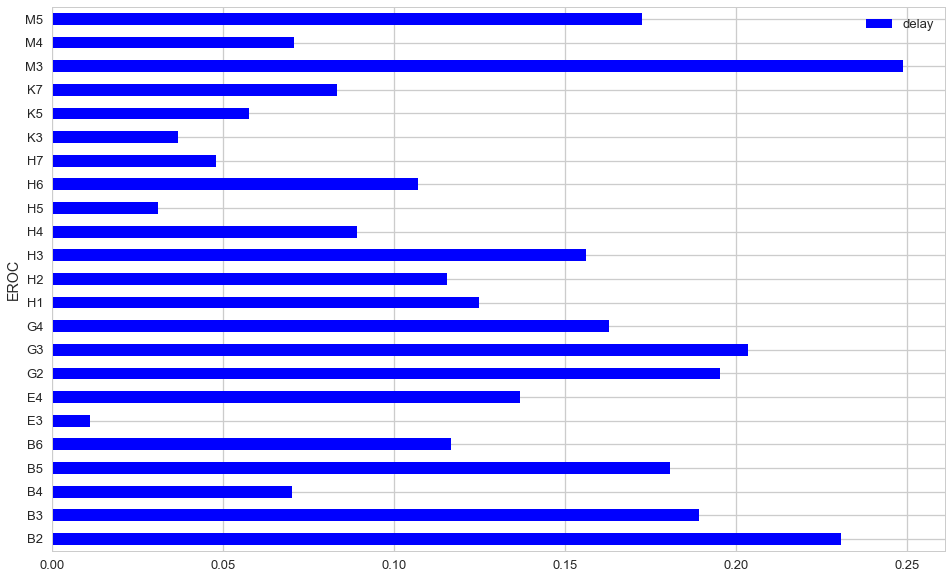

In [48]:
# Plot proportion delayed by EROC
count_prop_EROC.plot(y='delay', use_index=True, kind='barh', figsize=[16,10], colormap='winter')

In [32]:
# groupby River_Code to get counts by River
group_by_river = traf_sample_delay.groupby(['RIVER_CODE','delay'])

In [33]:
# view categories by size and unstack by RIVER_CODE
count_delays_by_river = group_by_river.size().unstack()

In [34]:
# calculate proportion of lockage events by river that are 'delays' (>110min)
prop_by_river = pd.DataFrame(traf_sample_delay.groupby('RIVER_CODE')['delay'].apply(lambda x: np.sum(x)/len(x)))

In [94]:
# set index of rivermstr to river_code
rivers = rivermstr.set_index('RIVER_CODE')

# Join rivers with count_delays_by_river to provide river names
delays_rivername = rivers.join(count_delays_by_river)

# Join delays_rivername with prop_by_river, view highest proportion of delays first
count_prop_river = delays_rivername.join(prop_by_river)
count_prop_river.sort_values(by=['delay'], ascending=False, inplace=True, )
count_prop_river

RIVER_NAME    False     True     delay
RIVER_CODE                                                            
OD                               OLD RIVER   1612.0    535.0  0.249185
GI              GULF INTRACOASTAL WATERWAY  63052.0  20441.0  0.244823
FB                        FRESHWATER BAYOU   6050.0   1813.0  0.230574
WS              LAKE WASHINGTON SHIP CANAL   7370.0   1882.0  0.203415
AT                       ATCHAFALAYA RIVER   1505.0    375.0  0.199468
CO                          COLUMBIA RIVER   3823.0    944.0  0.198028
MI                       MISSISSIPPI RIVER  54343.0  11308.0  0.172244
TN                         TENNESSEE RIVER  11259.0   2266.0  0.167542
IL                       ILLINOIS WATERWAY  16661.0   2811.0  0.144361
SN                             SNAKE RIVER   1961.0    326.0  0.142545
AI          ATLANTIC INTRACOASTAL WATERWAY   2315.0    382.0  0.141639
KA                           KANAWHA RIVER   3109.0    440.0  0.123979
OH                              OHIO RIVER  58601.0   8068.0  0.121016
DS                DISMAL SWAMP CANAL ROUTE    652.0     88.0  0.118919
OB               OUACHITA and BLACK RIVERS    938.0    122.0  0.115094
CU                        CUMBERLAND RIVER   3388.0    440.0  0.114943
CH                           CHICAGO RIVER   9396.0   1125.0  0.106929
MK            MC-KERR ARKANSAS RIV NAV SYS  15239.0   1633.0  0.096788
SM                         ST. MARYS RIVER   3767.0    363.0  0.087893
BW           BLACKWARRIOR/TOMBIGBEE RIVERS   5501.0    511.0  0.084997
FR                         CAPE FEAR RIVER     11.0      1.0  0.083333
MN                       MONONGAHELA RIVER  13507.0    988.0  0.068161
AG                         ALLEGHENY RIVER   5135.0    327.0  0.059868
RR                               RED RIVER   3489.0    212.0  0.057282
OK                     OKEECHOBEE WATERWAY  11669.0    607.0  0.049446
TT            TENNESSEE TOMBIGBEE WATERWAY  11962.0    569.0  0.045407
BR          BLACK ROCK CH/TONAWANDA HARBOR   1000.0     32.0  0.031008
GB                   GREEN & BARREN RIVERS   2537.0     45.0  0.017428
CA                         CALCASIEU RIVER   2706.0     44.0  0.016000
HU                            HUDSON RIVER   1523.0     17.0  0.011039
AP          APLCHCLA/CHATTAHO/FLINT RIVERS    130.0      1.0  0.007634
AL                    ALABAMA-COOSA RIVERS    131.0      1.0  0.007576
CN                        CANAVERAL HARBOR   4578.0     12.0  0.002614
IN                        THE INLAND ROUTE   3592.0      6.0  0.001668
KS                         KASKASKIA RIVER    752.0      1.0  0.001328
BT                             BAYOU TECHE      NaN      NaN       NaN
CI                            CLINCH RIVER      NaN      NaN       NaN
WI                        WILLAMETTE RIVER      NaN      NaN       NaN
00                                    NONE      NaN      NaN       NaN

In [38]:
# groupby LOCKAGE_TYPE to see counts by LOCKAGE_TYPE
group_by_LOCKAGE = traf_sample_delay.groupby(['LOCKAGE_TYPE','delay'])

In [39]:
# view categories by size and unstack by LOCKAGE_TYPE
# A = Barges After Tow, B = Barges Before Tow, C = Consecutive, F = Fast Double
# J = Jacknife, K = Knockout, N = Navigable Pass, O = Open Pass, S = Straight
# T = Barge Transfer, V = Setover, Z = other
count_delays_by_lockage = group_by_LOCKAGE.size().unstack()

In [40]:
# calculate percent of lockage events that are 'delays' (>110min)
prop_by_lockage = pd.DataFrame(traf_sample_delay.groupby('LOCKAGE_TYPE')['delay'].apply(lambda x: np.sum(x)/len(x)))

# Join count_delays_by_lockage with prop_by_lockage
count_prop_lockage = count_delays_by_lockage.join(prop_by_lockage)
count_prop_lockage

False   True     delay
LOCKAGE_TYPE                         
A                  9      3  0.250000
B               7668   2724  0.262125
C              38607  14460  0.272486
F                592     31  0.049759
J                 12      7  0.368421
K              10461   1303  0.110762
N              10277    432  0.040340
O              39281   9849  0.200468
S             225330  29660  0.116318
T                 11      2  0.153846
V                962    254  0.208882
Z                 54     11  0.169231

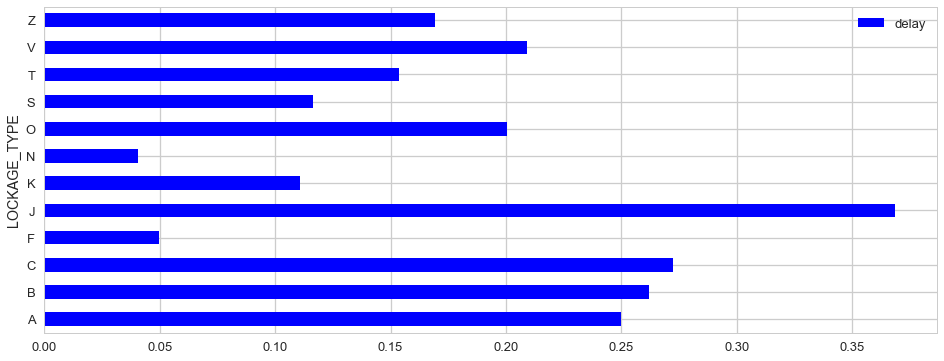

In [46]:
# Plot proportion delayed by Lockage Type
count_prop_lockage.plot(y='delay', use_index = True, kind='barh', figsize=[16,6], colormap='winter')

In [49]:
# groupby LOCKA_NO to see counts by lock number: group_by_LOCK_NO
group_by_LOCK_NO = traf_sample_delay.groupby(['E_R_L', 'delay'])

In [50]:
# view categories by size and unstack by LOCK_NO
delays_lock_no = group_by_LOCK_NO.size().unstack()

In [69]:
# calculate percent of lockage events that are 'delays' (>110min)
prop_by_lock_no = pd.DataFrame(traf_sample_delay.groupby('E_R_L')['delay'].apply(lambda x: np.sum(x)/len(x)))

# Join count_delays_by_lock_no with prop_by_lock_no, view highest proportion of delays first
prop_lock_no = delays_lock_no.join(prop_by_lock_no)
prop_lock_no.sort_values(by=['delay'], ascending=False, inplace=True)
prop_lock_no.head()

False    True     delay
E_R_L                            
K7_FR_2     1.0     1.0  0.500000
B4_OB_4    37.0    13.0  0.260000
H3_TN_8   753.0   251.0  0.250000
B2_GI_3  3949.0  1316.0  0.249953
B2_GI_1  3185.0  1059.0  0.249529

In [53]:
# examine the top 10 delayed locks
prop_lock_no.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, K7_FR_2 to K5_AL_11
Data columns (total 3 columns):
False    186 non-null float64
True     180 non-null float64
delay    186 non-null float64
dtypes: float64(3)
memory usage: 5.8+ KB


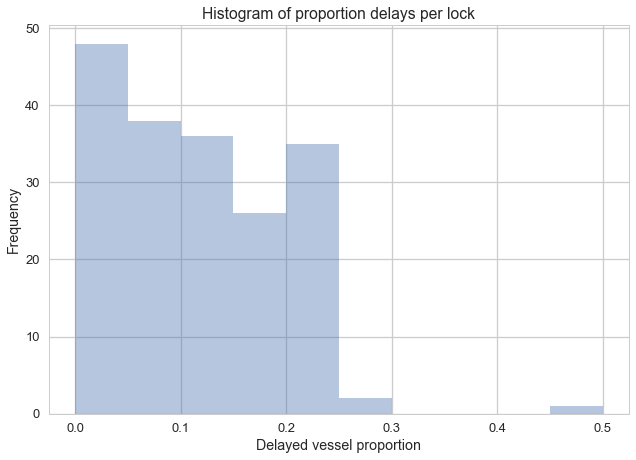

In [70]:
# Examine distribution of proportions of lock delays
sns.distplot(prop_lock_no.delay, bins=10, kde=False, rug=False);
plt.title('Histogram of proportion delays per lock');
plt.xlabel('Delayed vessel proportion');
plt.ylabel('Frequency');

## 4. Assign Delay Cateogories HIGH or LOW to Individual Locks Based on Proportion of Delays

In [75]:
# Assign each Lock as LOW or HIGH in prop_lock_no dataframe
prop_lock_no['cat_delay'] = np.where(prop_lock_no['delay'] > 0.15, 'HIGH', 'LOW')
prop_lock_no.rename(columns={'delay':'prop_delay'}, inplace=True)
prop_lock_no.head()

False    True  prop_delay cat_delay
E_R_L                                        
K7_FR_2     1.0     1.0    0.500000      HIGH
B4_OB_4    37.0    13.0    0.260000      HIGH
H3_TN_8   753.0   251.0    0.250000      HIGH
B2_GI_3  3949.0  1316.0    0.249953      HIGH
B2_GI_1  3185.0  1059.0    0.249529      HIGH

In [76]:
prop_lock_no.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, K7_FR_2 to K5_AL_11
Data columns (total 4 columns):
False         186 non-null float64
True          180 non-null float64
prop_delay    186 non-null float64
cat_delay     186 non-null object
dtypes: float64(3), object(1)
memory usage: 7.3+ KB


In [78]:
# Assign LOW & HIGH 'cat_delay' categories to each row based on lock ID 'E_R_L'
# Use pd.merge to add cat_delay category into a column
traf_sample_delay_cat = pd.merge(traf_sample_delay, prop_lock_no, how='left', right_index=True, left_on='E_R_L', right_on='E_R_L')
traf_sample_delay_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392000 entries, 0 to 391999
Data columns (total 32 columns):
EROC                    392000 non-null object
RIVER_CODE              392000 non-null object
LOCK_NO                 392000 non-null int64
CHMBR_NO                392000 non-null int64
OPS_ID                  392000 non-null object
LOCKAGE_TYPE            392000 non-null object
VESSEL_NO               392000 non-null int64
VESSEL_FUNCTION_TYPE    390657 non-null object
FLOTILLA_NO             269205 non-null object
ARRIVAL_DATE            392000 non-null datetime64[ns]
SOL_DATE                392000 non-null datetime64[ns]
BOW_OVER_SILL           281505 non-null datetime64[ns]
END_OF_ENTRY            281518 non-null datetime64[ns]
START_OF_EXIT           281561 non-null datetime64[ns]
END_OF_LOCKAGE          392000 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       54260 non-null float64
ASST_CODE               27485 non-null object
SIGNAL_DATE             813 non-null datetime6

In [80]:
# New Main Traffic dataframe. Next step (see below) is to remove outliers, remove 'low' category, pick focal locks...
traf_sample_delay_cat.head()

EROC RIVER_CODE  LOCK_NO  CHMBR_NO    OPS_ID LOCKAGE_TYPE   VESSEL_NO  \
0   H2         OH       75         2  L5608584            S  2246973225   
1   M5         MK       22         1  L7532719            C   967995540   
2   M3         GI       14         1  L6150873            O  3171419219   
3   H4         MN       25         1  L6581479            S  2064406338   
4   M3         GI       13         1  L7255211            O  1088709797   

  VESSEL_FUNCTION_TYPE FLOTILLA_NO        ARRIVAL_DATE    ...     delay_time  \
0                    T    L3435504 2014-05-07 05:37:00    ...           10.0   
1                    T    L4611089 2017-04-06 00:40:00    ...            0.0   
2                    T    L3767838 2015-02-10 20:00:00    ...           66.0   
3                    T    L4017674 2015-09-20 02:20:00    ...           20.0   
4                    T    L4420842 2016-10-01 01:08:00    ...           67.0   

   delay     E_R_L      YYMMDD    hhmmss  pct75_delay_time   False    True  \
0  False  H2_OH_75  2014-05-07  05:37:00             146.0  3165.0   652.0   
1  False  M5_MK_22  2017-04-06  00:40:00             105.0   762.0   156.0   
2  False  M3_GI_14  2015-02-10  20:00:00             197.0  6543.0  2171.0   
3  False  H4_MN_25  2015-09-20  02:20:00              39.0  2179.0    85.0   
4  False  M3_GI_13  2016-10-01  01:08:00             216.0  6569.0  2177.0   

  prop_delay  cat_delay  
0   0.170815       HIGH  
1   0.169935       HIGH  
2   0.249139       HIGH  
3   0.037544        LOW  
4   0.248914       HIGH  

[5 rows x 32 columns]

## 5. Explore Patterns in Delay Count by Year, Month, Day for Vessels

In [54]:
# Remove all 'delay' = False rows: only_delay
only_delay = traf_sample_delay.query('delay != False')
only_delay.head()

EROC RIVER_CODE  LOCK_NO  CHMBR_NO    OPS_ID LOCKAGE_TYPE   VESSEL_NO  \
19   M3         GI       12         1  L6187320            O  1504534824   
31   B6         MI        9         1  L5669493            C  4092571819   
39   B2         GI        4         1  L6475971            S  3020701214   
43   B2         GI        8         1  L7514042            S  1815299047   
72   B5         IL        8         1  L6125614            C   291263268   

   VESSEL_FUNCTION_TYPE FLOTILLA_NO        ARRIVAL_DATE        ...         \
19                    T    L3795181 2015-03-14 03:10:00        ...          
31                    T    L3472944 2014-06-05 12:10:00        ...          
39                    T    L3963416 2015-08-03 09:33:00        ...          
43                    T    L4598081 2017-03-25 14:08:00        ...          
72                    T    L3748619 2015-01-23 09:00:00        ...          

   DEPARTURE_DATE LINE_SEQ_NO entry_time exit_time delay_time  delay  \
19            NaT      988292        NaN       NaN       70.0   True   
31            NaT       51407        9.0      25.0       89.0   True   
39            NaT       12767       10.0      10.0      649.0   True   
43            NaT      836439        2.0       4.0      263.0   True   
72            NaT      733302        6.0      24.0      470.0   True   

       E_R_L      YYMMDD    hhmmss  pct75_delay_time  
19  M3_GI_12  2015-03-14  03:10:00              38.0  
31   B6_MI_9  2014-06-05  12:10:00              83.5  
39   B2_GI_4  2015-08-03  09:33:00             470.0  
43   B2_GI_8  2017-03-25  14:08:00             190.0  
72   B5_IL_8  2015-01-23  09:00:00             346.0  

[5 rows x 28 columns]

In [55]:
# Explore delays per year
group_year = only_delay.groupby(pd.Grouper(key='ARRIVAL_DATE', freq="Y")) 
count_delays_by_year = group_year.size()
count_delays_by_year

ARRIVAL_DATE
2013-12-31     9150
2014-12-31    11553
2015-12-31    12493
2016-12-31    12749
2017-12-31    12791
Freq: A-DEC, dtype: int64

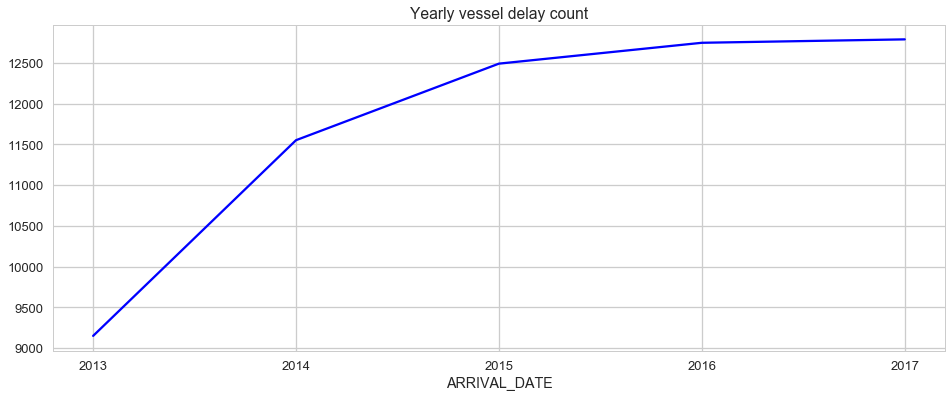

In [56]:
# Plot count of delayed vessels by year
count_delays_by_year.plot(kind='line', figsize=[16,6], colormap='winter',
                         title='Yearly vessel delay count')

In [57]:
# Explore delays per month
group_month = only_delay.groupby(pd.Grouper(key='ARRIVAL_DATE', freq="M")) 
count_delays_by_month = group_month.size()

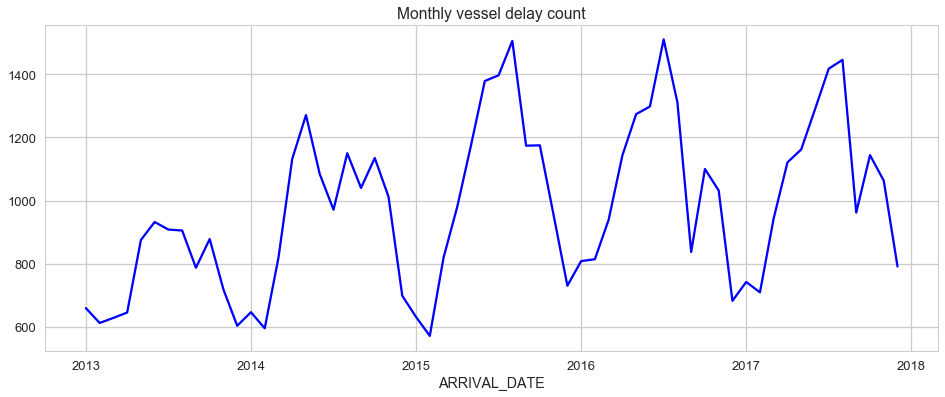

In [58]:
# Plot count of delayed vessels by month
count_delays_by_month.plot(kind='line', figsize=[16,6], colormap='winter',
                         title='Monthly vessel delay count')

In [59]:
# Explore delays per day
group_day = only_delay.groupby(pd.Grouper(key='ARRIVAL_DATE', freq="D")) 
count_delays_by_day = group_day.size()

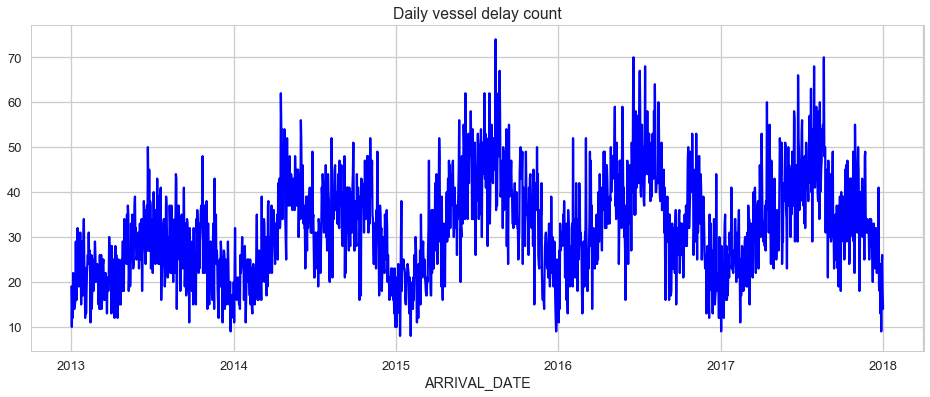

In [60]:
# Plot count of delayed vessels by day
count_delays_by_day.plot(kind='line', figsize=[16,6], colormap='winter',
                         title='Daily vessel delay count')

## 6.  Examine Delays Per Lock & Per Day

In [144]:
# Group by lock and day with count of delay (true/false)
lock_year = pd.DataFrame(traf_sample_delay.groupby(['E_R_L','YYMMDD', 'delay'])['delay'].count())
lock_year.head()

delay
E_R_L    YYMMDD     delay       
B2_AT_11 2013-01-01 False      2
         2013-01-04 False      2
         2013-01-06 False      1
         2013-01-07 False      1
         2013-01-08 False      1

In [145]:
# turn 'delay' index into a column
lock_year.rename(columns={'delay':'count'}, inplace=True)
lock_year.reset_index(inplace=True) 
lock_year.head()

E_R_L      YYMMDD  delay  count
0  B2_AT_11  2013-01-01  False      2
1  B2_AT_11  2013-01-04  False      2
2  B2_AT_11  2013-01-06  False      1
3  B2_AT_11  2013-01-07  False      1
4  B2_AT_11  2013-01-08  False      1

In [189]:
# Tranform 'YYMMDD' to datetime field
lock_year['YYMMDD'] = pd.to_datetime(lock_year['YYMMDD'])

# Use pd.Grouper to get counts of True and False rows per Lock/Year
delay_day_lock = lock_year.groupby(by=[pd.Grouper(key='E_R_L'), pd.Grouper(key='YYMMDD', freq='Y'),
                                                pd.Grouper(key='delay')]).count()
delay_day_lock2 = delay_day_lock.unstack()

# reset each level of index, drop hierarchical columns, rename columns if needed
delay_day_lock2.reset_index(level='E_R_L',inplace=True) # iterate through each level
delay_day_lock2.columns = delay_day_lock2.columns.droplevel(0)
#delay_day_lock2.columns = ['E_R_L', 'YYMMDD', 'False', 'True']

# Calculate annual percentage of days with delay
delay_day_lock2['yearly_delay_days'] = (delay_day_lock2['True'] / 365)
delay_day_lock2.head()

E_R_L     YYMMDD  False   True  yearly_delay_days
0  B2_AT_11 2013-12-31  124.0  123.0           0.336986
1  B2_AT_11 2014-12-31  180.0   51.0           0.139726
2  B2_AT_11 2015-12-31  169.0   66.0           0.180822
3  B2_AT_11 2016-12-31  190.0   15.0           0.041096
4  B2_AT_11 2017-12-31  171.0    6.0           0.016438

In [213]:
# Calculate statistics of yearly delays per lock
year_daily = delay_day_lock2.pivot_table(columns='E_R_L', values='yearly_delay_days', aggfunc=[np.mean])

# convert to dataframe and transpose
year_daily_stats = pd.DataFrame(year_daily).T
year_daily_stats.reset_index(inplace=True)
year_daily_stats.drop(labels='level_0', axis='columns', inplace=True)
year_daily_stats.set_index('E_R_L', inplace=True)
year_daily_stats.head(10)

yearly_delay_days
E_R_L                      
B2_AT_11           0.143014
B2_CA_23           0.023014
B2_FB_41           0.513425
B2_GI_1            0.333151
B2_GI_2            0.437808
B2_GI_21           0.023562
B2_GI_22           0.046575
B2_GI_3            0.322740
B2_GI_4            0.326027
B2_GI_5            0.243288

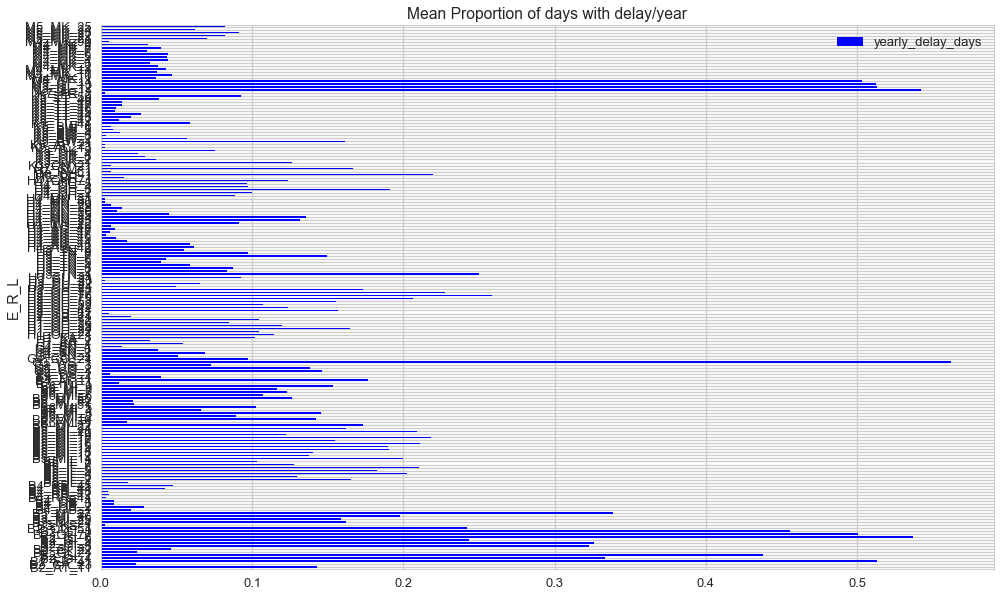

In [214]:
# Plot mean annual delay proportion
year_daily_stats.plot(kind='barh', figsize=[16,10], colormap='winter', title='Mean Proportion of days with delay/year')

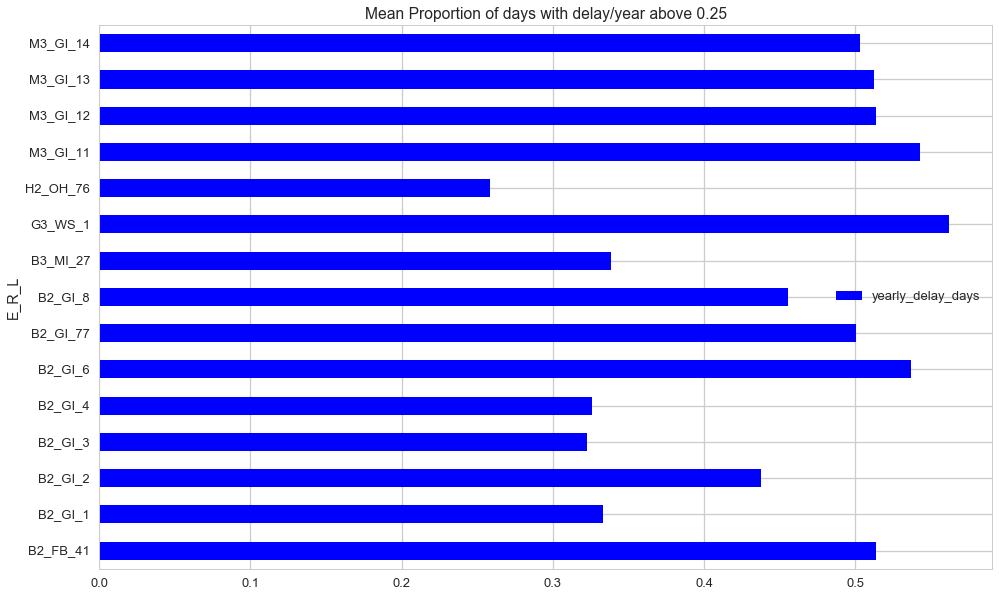

In [215]:
# Keep only locks with delay proportions over 0.25
year_daily_high = year_daily_stats[year_daily_stats['yearly_delay_days'] > 0.25]
year_daily_high.plot(kind='barh', figsize=[16,10], colormap='winter',
                     title='Mean Proportion of days with delay/year above 0.25')

In [216]:
# These are the locks with the highest proportion of delay-days per year
year_daily_high.head(20)
# I selected 10 of these for the reduced ML dataset: 
# B2_FB_41, B2_GI_3, B2_GI_4, B2_GI_77, B3_MI_27, G3_WS_1, H2_OH_76, M3_GI_11, M3_GI_12, M3_GI_14

yearly_delay_days
E_R_L                      
B2_FB_41           0.513425
B2_GI_1            0.333151
B2_GI_2            0.437808
B2_GI_3            0.322740
B2_GI_4            0.326027
B2_GI_6            0.536986
B2_GI_77           0.500274
B2_GI_8            0.455342
B3_MI_27           0.338630
G3_WS_1            0.562192
H2_OH_76           0.258630
M3_GI_11           0.542466
M3_GI_12           0.513425
M3_GI_13           0.512329
M3_GI_14           0.503014

In [204]:
# Most locks have a low proportion of days with delays
year_daily_stats.describe()

yearly_delay_days
count         180.000000
mean            0.110956
std             0.122796
min             0.002740
25%             0.022740
50%             0.078904
75%             0.153699
max             0.562192

In [193]:
# Majority of Locks per Day have 2 or fewer vessels. Max count of True or false at one Lock on one day is 27.
lock_year.describe()

count
count  197971.000000
mean        1.980088
std         1.522788
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        27.000000

### The 'lock_year' dataframe can be used to create subplots by lock of True/False delay counts over time.

In [81]:
# pickle modified traf_sample_delay for later use. This dataframe has delay defined per lock.
traf_sample_delay_cat.to_pickle('traf_sample_delay.pickle')

## 7. Start to Build Focal DataFrame for Machine Learning

In [220]:
# Remove all delay_cat = 'LOW' rows
ML = traf_sample_delay_cat[traf_sample_delay_cat.cat_delay != 'LOW']

# Remove outlier lock, K7_FR_2. It has low traffic but very high ratio of delays
ML_traf = ML[ML.E_R_L != 'K7_FR_2']

# Remove individual rivers with fewer than 10 delays over 5 years
to_drop = ['FR', 'AP', 'AL', 'IN', 'KS', 'BT', 'CT', 'WI', 'HU', 'CN']
ML_traf_sample = ML_traf.query('RIVER_CODE not in @to_drop')

# Remove individual locks with fewer than 1000 delays over 5 years
drop_lock = ['G2_CO_2', 'G4_CO_24', 'M5_MK_23', 'M5_MK_22', 'H3_TN_8', 'H1_KA_3', 'M5_MK_21', 
             'M5_MK_25', 'H3_TN_9', 'B4_RR_45', 'G4_SN_2', 'B2_GI_22', 'E4_DS_1', 'B4_OB_1', 
             'B4_OB_2', 'B4_OB_3', 'B4_OB_4']
ML_traf_sample_drop = ML_traf_sample.query('E_R_L not in @drop_lock')
ML_traf_sample_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182169 entries, 0 to 391999
Data columns (total 32 columns):
EROC                    182169 non-null object
RIVER_CODE              182169 non-null object
LOCK_NO                 182169 non-null int64
CHMBR_NO                182169 non-null int64
OPS_ID                  182169 non-null object
LOCKAGE_TYPE            182169 non-null object
VESSEL_NO               182169 non-null int64
VESSEL_FUNCTION_TYPE    182152 non-null object
FLOTILLA_NO             147736 non-null object
ARRIVAL_DATE            182169 non-null datetime64[ns]
SOL_DATE                182169 non-null datetime64[ns]
BOW_OVER_SILL           124013 non-null datetime64[ns]
END_OF_ENTRY            124009 non-null datetime64[ns]
START_OF_EXIT           124030 non-null datetime64[ns]
END_OF_LOCKAGE          182169 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       8812 non-null float64
ASST_CODE               15195 non-null object
SIGNAL_DATE             813 non-null datetime64

In [221]:
# Group by lock and day with count of delay (true/false)
lock_day = pd.DataFrame(ML_traf_sample_drop.groupby(['E_R_L', 'YYMMDD', 'delay'])['delay'].count())
lock_day.columns = ['count']
lock_day.reset_index(level='delay', inplace=True)
lock_day.reset_index(level='YYMMDD', inplace=True) # had to do this one index at a time with level='delay', etc
lock_day.reset_index(level='E_R_L', inplace=True)
lock_day.head()

E_R_L      YYMMDD  delay  count
0  B2_AT_11  2013-01-01  False      2
1  B2_AT_11  2013-01-04  False      2
2  B2_AT_11  2013-01-06  False      1
3  B2_AT_11  2013-01-07  False      1
4  B2_AT_11  2013-01-08  False      1

In [223]:
# randomize the order of rows and drop duplicate rows for the subset of columns ['E_R_L','YYMMDD','delay']
ML_traf_sample_final = ML_traf_sample_drop.sample(frac=1, random_state=42).drop_duplicates(subset=['E_R_L','YYMMDD','delay'])
ML_traf_sample_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80081 entries, 256449 to 271865
Data columns (total 32 columns):
EROC                    80081 non-null object
RIVER_CODE              80081 non-null object
LOCK_NO                 80081 non-null int64
CHMBR_NO                80081 non-null int64
OPS_ID                  80081 non-null object
LOCKAGE_TYPE            80081 non-null object
VESSEL_NO               80081 non-null int64
VESSEL_FUNCTION_TYPE    80070 non-null object
FLOTILLA_NO             64768 non-null object
ARRIVAL_DATE            80081 non-null datetime64[ns]
SOL_DATE                80081 non-null datetime64[ns]
BOW_OVER_SILL           61107 non-null datetime64[ns]
END_OF_ENTRY            61104 non-null datetime64[ns]
START_OF_EXIT           61112 non-null datetime64[ns]
END_OF_LOCKAGE          80081 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       3582 non-null float64
ASST_CODE               8158 non-null object
SIGNAL_DATE             284 non-null datetime64[ns]
DEPARTU

In [224]:
# pickle ML_traf_sample_final for later use. This dataframe has one row per lock/day/delay
ML_traf_sample_final.to_pickle('ML_traf_sample_final.pickle')

## 8. Delete unneccesary columns, create full and reduced datasets for ML

In [230]:
# Drop unneccessary rows from ML_traf_sample_final dataframe
ML_traf_full = ML_traf_sample_final.drop(['FLOTILLA_NO', 'SOL_DATE', 'BOW_OVER_SILL', 'END_OF_ENTRY', 'START_OF_EXIT',
                                         'END_OF_LOCKAGE', 'NUM_CMRCL_PASSGRS', 'SIGNAL_DATE', 'DEPARTURE_DATE',
                                         'cat_delay'], axis='columns')
ML_traf_full.sort_index(inplace=True)
ML_traf_full = ML_traf_full.reset_index(drop=True)
# Get list of columns to remove the last three and to put 'E_R_L' first
cols = list(ML_traf_full.columns.values)
print(cols)

['EROC', 'RIVER_CODE', 'LOCK_NO', 'CHMBR_NO', 'OPS_ID', 'LOCKAGE_TYPE', 'VESSEL_NO', 'VESSEL_FUNCTION_TYPE', 'ARRIVAL_DATE', 'ASST_CODE', 'LINE_SEQ_NO', 'entry_time', 'exit_time', 'delay_time', 'delay', 'E_R_L', 'YYMMDD', 'hhmmss', 'pct75_delay_time', False, True, 'prop_delay']


In [231]:
ML_traf_full = ML_traf_full[['E_R_L', 'YYMMDD', 'EROC', 'RIVER_CODE', 'LOCK_NO', 'CHMBR_NO', 'OPS_ID', 'LOCKAGE_TYPE', 'VESSEL_NO', 
                             'VESSEL_FUNCTION_TYPE', 'ARRIVAL_DATE', 'ASST_CODE', 'LINE_SEQ_NO', 'entry_time', 
                             'exit_time', 'delay_time', 'delay','hhmmss', 'pct75_delay_time']]
ML_traf_full.head()

E_R_L      YYMMDD EROC RIVER_CODE  LOCK_NO  CHMBR_NO    OPS_ID  \
0  B5_MI_15  2013-04-02   B5         MI       15         1  L4892914   
1   B2_GI_1  2017-09-01   B2         GI        1         1  L7836405   
2   B5_IL_2  2014-03-13   B5         IL        2         1  L5514688   
3   B2_GI_4  2015-07-24   B2         GI        4         1  L6449717   
4   B6_MI_8  2014-05-04   B6         MI        8         1  L5605329   

  LOCKAGE_TYPE   VESSEL_NO VESSEL_FUNCTION_TYPE        ARRIVAL_DATE ASST_CODE  \
0            S   801227182                    T 2013-04-02 03:55:00         J   
1            S   356322780                    T 2017-09-01 11:20:00       NaN   
2            K  3026493802                    T 2014-03-13 18:19:00       NaN   
3            S  1738273732                    T 2015-07-24 03:41:00       NaN   
4            C   291263268                    T 2014-05-04 16:38:00       NaN   

   LINE_SEQ_NO  entry_time  exit_time  delay_time  delay    hhmmss  \
0       162898        20.0       20.0         0.0  False  03:55:00   
1       981839         5.0        8.0        91.0  False  11:20:00   
2       444353         9.0       13.0         6.0  False  18:19:00   
3       927674         5.0        4.0       437.0  False  03:41:00   
4       808533         6.0       18.0        50.0  False  16:38:00   

   pct75_delay_time  
0             213.0  
1             298.0  
2             126.0  
3             470.0  
4             105.0

In [232]:
# now make ML_traf_small
lock_list = ['B2_FB_41', 'B2_GI_3', 'B2_GI_4', 'B2_GI_77', 'B3_MI_27', 'G3_WS_1', 'H2_OH_76', 'M3_GI_11', 
             'M3_GI_12', 'M3_GI_14']
ML_traf_reduced = ML_traf_full[ML_traf_full['E_R_L'].isin(lock_list)]
ML_traf_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23913 entries, 3 to 80072
Data columns (total 19 columns):
E_R_L                   23913 non-null object
YYMMDD                  23913 non-null object
EROC                    23913 non-null object
RIVER_CODE              23913 non-null object
LOCK_NO                 23913 non-null int64
CHMBR_NO                23913 non-null int64
OPS_ID                  23913 non-null object
LOCKAGE_TYPE            23913 non-null object
VESSEL_NO               23913 non-null int64
VESSEL_FUNCTION_TYPE    23912 non-null object
ARRIVAL_DATE            23913 non-null datetime64[ns]
ASST_CODE               154 non-null object
LINE_SEQ_NO             23913 non-null int64
entry_time              13104 non-null float64
exit_time               13107 non-null float64
delay_time              23913 non-null float64
delay                   23913 non-null bool
hhmmss                  23913 non-null object
pct75_delay_time        23913 non-null float64
dtypes: bool(

In [233]:
# pickle ML_traf_full for later use. This dataframe has one row per lock/day/delay and many locks
ML_traf_full.to_pickle('ML_traf_full.pickle')

In [234]:
# pickle ML_traf_reduced for later use. This dataframe has one row per lock/day/delay and 10 locks
ML_traf_reduced.to_pickle('ML_traf_reduced.pickle')